Declare Imports

In [63]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

Initialize dataset

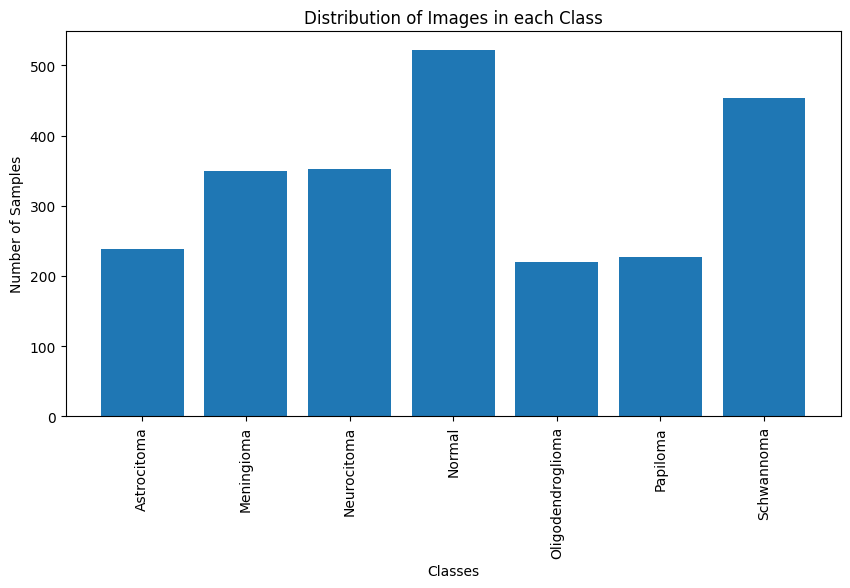

In [64]:
brain_tumor_dataset = r'C:\Users\Hamzah\Desktop\COMP 478\copy'

# Get all image classes and number of images in each class
classes = os.listdir(brain_tumor_dataset)
num_images = []
for c in classes:
    num_images.append(len(os.listdir(os.path.join(brain_tumor_dataset, c))))

# Plot the number of images in each class
plt.figure(figsize=(10, 5))
plt.bar(classes, num_images)
plt.title('Distribution of Images in each Class')
plt.xlabel('Classes')

# Rotate the x-axis labels
plt.xticks(rotation=90)

plt.ylabel('Number of Samples')
plt.show()

Split Dataset

In [65]:
# Generating Datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    brain_tumor_dataset,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=(224, 224),
    batch_size=32
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    brain_tumor_dataset,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=(224, 224),
    batch_size=32
)

Found 2363 files belonging to 7 classes.
Using 1891 files for training.
Found 2363 files belonging to 7 classes.
Using 472 files for validation.


Plot Sample Images in Dataset

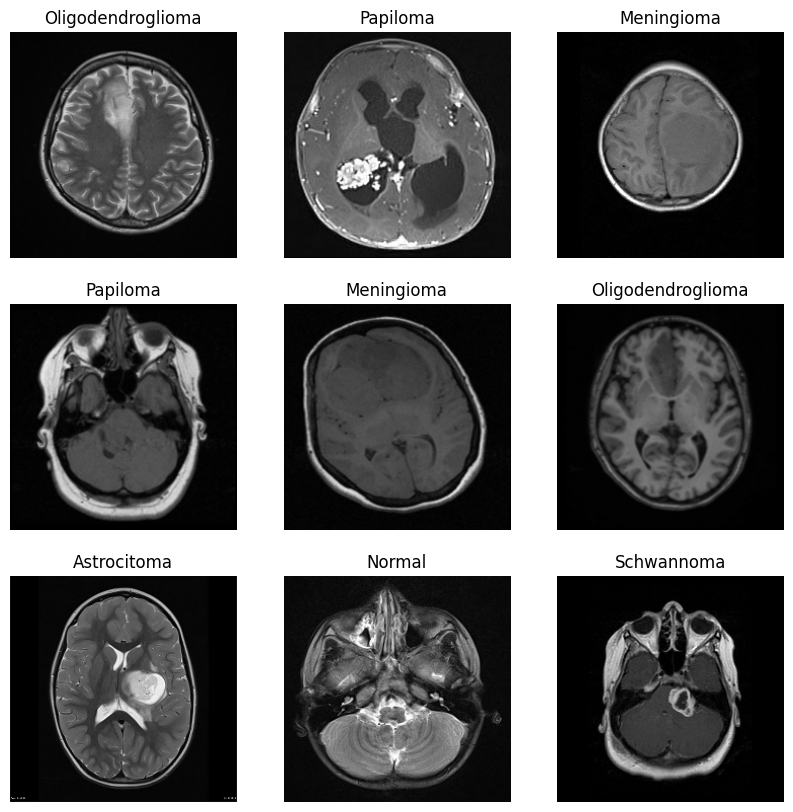

In [66]:
# Get an image from the training dataset for every class
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")



Data preparation & pre-processing

In [67]:
# Data Augmentation
data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(224, 224, 3)),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

# Rescale the images
rescale = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Rescaling(1./255)
    ]
)

# Rezise the images
resize = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Resizing(224, 224)
    ]
)

Plot Images Post Data Preperation and Pre-Processing 

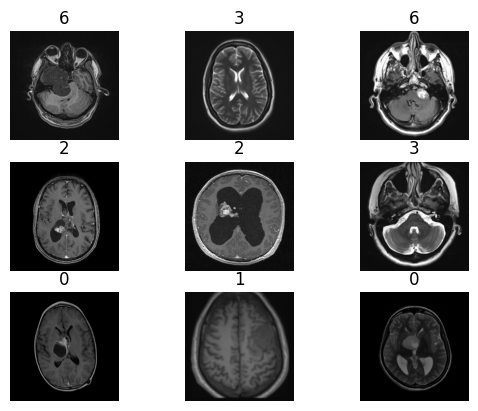

In [68]:
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Pre-trained VGG19 Model

In [69]:
#Creating a VGG19 model, and removing the last layer (the classification layer)
base_model_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_vgg19.trainable = False

#Adding a new classification layer
x = base_model_vgg19.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
predictions = layers.Dense(7, activation='softmax')(x)

#Creating a new model
model_vgg19 = Model(inputs=base_model_vgg19.input, outputs=predictions)

#Compiling the model
model_vgg19.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# use GPU for model fitting
with tf.device('/GPU:0'):
    history_vgg19 = model_vgg19.fit(train_ds, epochs=10, validation_data=val_ds)


Epoch 1/10
60/60 [==============================] - 145s 2s/step - loss: 1.4005 - accuracy: 0.6166 - val_loss: 0.7655 - val_accuracy: 0.7415
Epoch 2/10
60/60 [==============================] - 141s 2s/step - loss: 0.5603 - accuracy: 0.8075 - val_loss: 0.4744 - val_accuracy: 0.8369
Epoch 3/10
60/60 [==============================] - 144s 2s/step - loss: 0.3370 - accuracy: 0.8916 - val_loss: 0.6217 - val_accuracy: 0.8093
Epoch 4/10
60/60 [==============================] - 147s 2s/step - loss: 0.3480 - accuracy: 0.8900 - val_loss: 0.3257 - val_accuracy: 0.8962
Epoch 5/10
60/60 [==============================] - 145s 2s/step - loss: 0.1546 - accuracy: 0.9498 - val_loss: 0.3213 - val_accuracy: 0.9004
Epoch 6/10
60/60 [==============================] - 144s 2s/step - loss: 0.1108 - accuracy: 0.9646 - val_loss: 0.3561 - val_accuracy: 0.8898
Epoch 7/10
60/60 [==============================] - 144s 2s/step - loss: 0.0986 - accuracy: 0.9646 - val_loss: 0.3469 - val_accuracy: 0.8919
Epoch 8/10
60

Plotting VGG19 Model Accuraccy, Loss and Cofusion Matrix

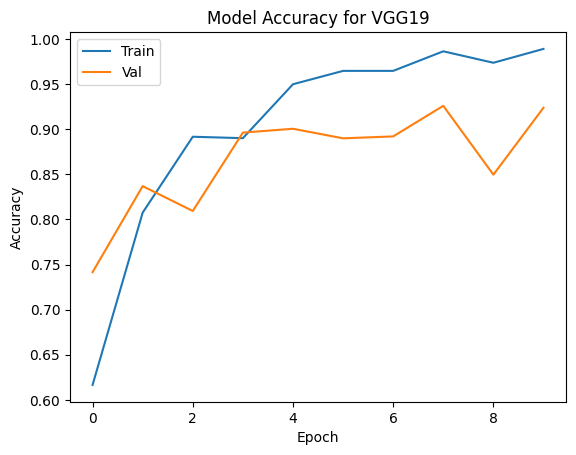

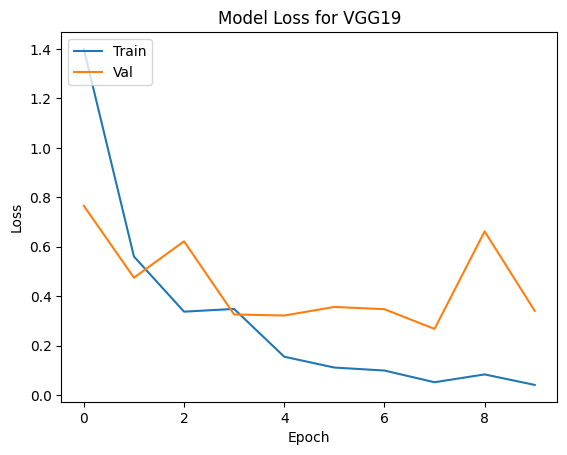

1/1 [==============================] - 3s 3s/step


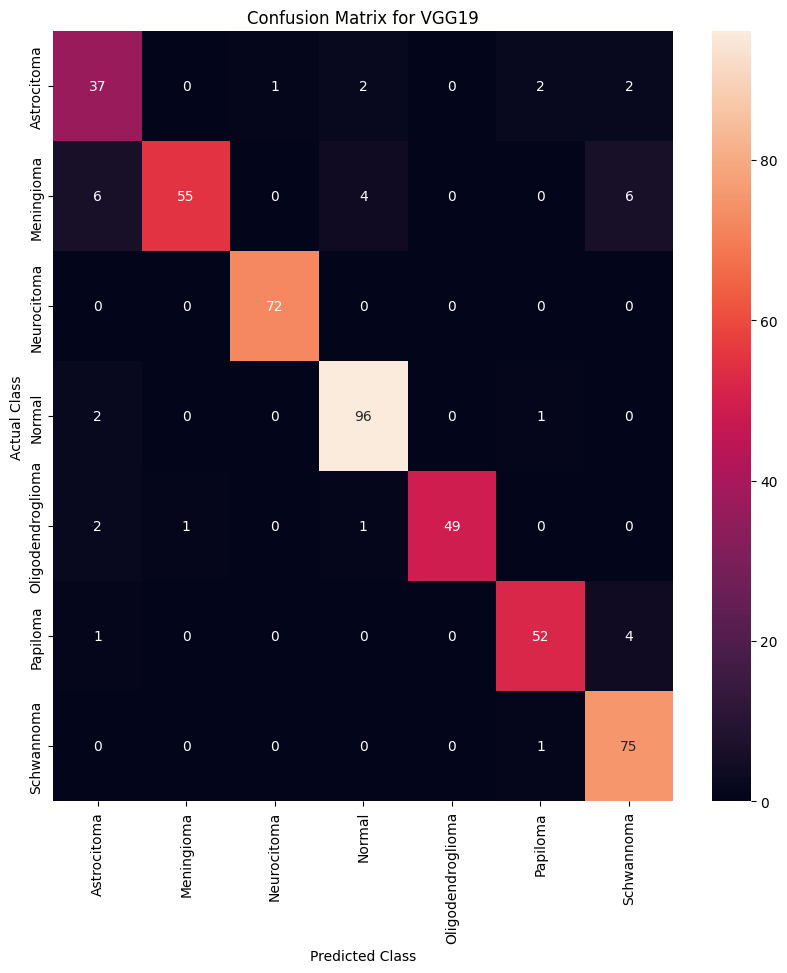

                   precision    recall  f1-score   support

      Astrocitoma       0.77      0.84      0.80        44
       Meningioma       0.98      0.77      0.87        71
      Neurocitoma       0.99      1.00      0.99        72
           Normal       0.93      0.97      0.95        99
Oligodendroglioma       1.00      0.92      0.96        53
         Papiloma       0.93      0.91      0.92        57
       Schwannoma       0.86      0.99      0.92        76

         accuracy                           0.92       472
        macro avg       0.92      0.92      0.92       472
     weighted avg       0.93      0.92      0.92       472



In [86]:
plt.plot(history_vgg19.history['accuracy'])
plt.plot(history_vgg19.history['val_accuracy'])
plt.title('Model Accuracy for VGG19')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

#Plotting the training and validation loss
plt.plot(history_vgg19.history['loss'])
plt.plot(history_vgg19.history['val_loss'])
plt.title('Model Loss for VGG19')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Get actual labels from the validation dataset
y_pred_vgg19 = []
y_actual_vgg19 = []

# use GPU for prediction
with tf.device('/GPU:0'):
    for images, labels in val_ds:
        
        # predict
        predictions = model_vgg19.predict(images)
        # get the predicted class
        predicted_class = np.argmax(predictions, axis=1)
        
        # append the predicted class
        for pred in predicted_class:
            y_pred_vgg19.append(pred)
        
        for label in labels:
            y_actual_vgg19.append(label)
            

#Plotting the confusion matrix
cm = confusion_matrix(y_actual_vgg19, y_pred_vgg19)
plt.figure(figsize=(10, 10))

# Set the labels based on the class names
labels = class_names

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for VGG19')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Print the classification report
print(classification_report(y_actual_vgg19, y_pred_vgg19, target_names=class_names))


Training ResNet50

In [73]:
#Train a ResNet50 model, and removing the last layer (the classification layer)
base_model_resnet50 = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_resnet50.trainable = False

#Adding a new classification layer
x = base_model_resnet50.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)

predictions = layers.Dense(7, activation='softmax')(x)

#Creating a new model
model_resnet50 = Model(inputs=base_model_resnet50.input, outputs=predictions)

#Compiling the model
model_resnet50.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# use GPU for model fitting
with tf.device('/GPU:0'):
    history_resnet50 = model_resnet50.fit(train_ds, epochs=10, validation_data=val_ds)


Epoch 1/10
60/60 [==============================] - 73s 1s/step - loss: 1.2684 - accuracy: 0.6029 - val_loss: 1.1472 - val_accuracy: 0.6229
Epoch 2/10
60/60 [==============================] - 68s 1s/step - loss: 0.5577 - accuracy: 0.8070 - val_loss: 0.5495 - val_accuracy: 0.8093
Epoch 3/10
60/60 [==============================] - 67s 1s/step - loss: 0.3446 - accuracy: 0.8810 - val_loss: 0.4478 - val_accuracy: 0.8475
Epoch 4/10
60/60 [==============================] - 68s 1s/step - loss: 0.2561 - accuracy: 0.9096 - val_loss: 0.4229 - val_accuracy: 0.8898
Epoch 5/10
60/60 [==============================] - 67s 1s/step - loss: 0.2129 - accuracy: 0.9265 - val_loss: 0.5963 - val_accuracy: 0.7987
Epoch 6/10
60/60 [==============================] - 66s 1s/step - loss: 0.1445 - accuracy: 0.9513 - val_loss: 0.8093 - val_accuracy: 0.8114
Epoch 7/10
60/60 [==============================] - 66s 1s/step - loss: 0.1519 - accuracy: 0.9498 - val_loss: 0.3756 - val_accuracy: 0.8877
Epoch 8/10
60/60 [==

Plotting ResNet50 Model Accuraccy, Loss and Cofusion Matrix

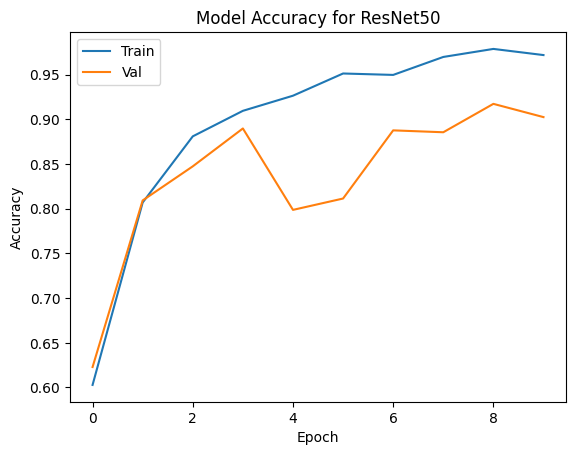

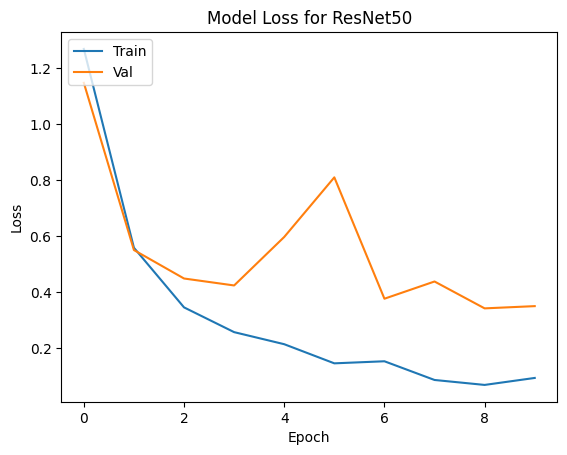

1/1 [==============================] - 1s 984ms/step


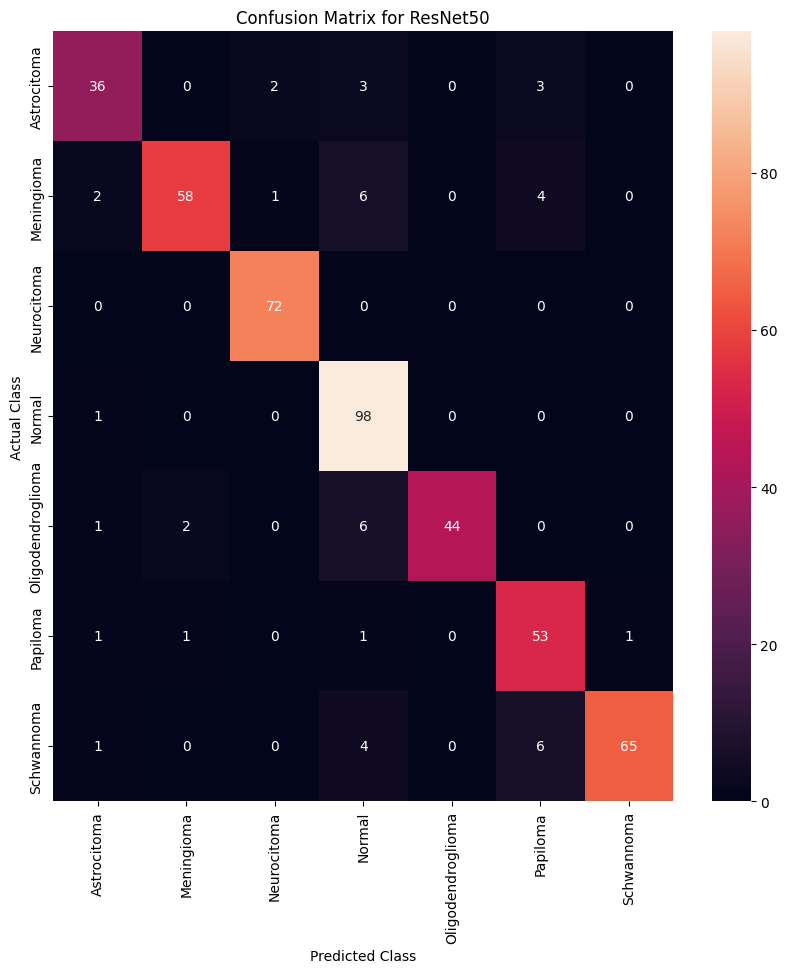

                   precision    recall  f1-score   support

      Astrocitoma       0.86      0.82      0.84        44
       Meningioma       0.95      0.82      0.88        71
      Neurocitoma       0.96      1.00      0.98        72
           Normal       0.83      0.99      0.90        99
Oligodendroglioma       1.00      0.83      0.91        53
         Papiloma       0.80      0.93      0.86        57
       Schwannoma       0.98      0.86      0.92        76

         accuracy                           0.90       472
        macro avg       0.91      0.89      0.90       472
     weighted avg       0.91      0.90      0.90       472



In [85]:
# Plotting the training and validation accuracy
plt.plot(history_resnet50.history['accuracy'])
plt.plot(history_resnet50.history['val_accuracy'])
plt.title('Model Accuracy for ResNet50')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plotting the training and validation loss
plt.plot(history_resnet50.history['loss'])
plt.plot(history_resnet50.history['val_loss'])
plt.title('Model Loss for ResNet50')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Get actual labels from the validation dataset
y_pred_resnet50 = []
y_actual_resnet50 = []

# use GPU for prediction
with tf.device('/GPU:0'):
    for images, labels in val_ds:
        
        # predict
        predictions = model_resnet50.predict(images)
        # get the predicted class
        predicted_class = np.argmax(predictions, axis=1)
        
        # append the predicted class
        for pred in predicted_class:
            y_pred_resnet50.append(pred)
        
        for label in labels:
            y_actual_resnet50.append(label)

# Plotting the confusion matrix
cm = confusion_matrix(y_actual_resnet50, y_pred_resnet50)
plt.figure(figsize=(10, 10))

# Set the labels based on the class names
labels = class_names

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for ResNet50')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Print the classification report
print(classification_report(y_actual_resnet50, y_pred_resnet50, target_names=class_names))

Training InceptionV3 Network

In [75]:
#Train a InceptionV3 model, and removing the last layer (the classification layer)
base_model_inceptionv3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_inceptionv3.trainable = False

#Adding a new classification layer
x = base_model_inceptionv3.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)

predictions = layers.Dense(7, activation='softmax')(x)

#Creating a new model
model_inceptionv3 = Model(inputs=base_model_inceptionv3.input, outputs=predictions)

#Compiling the model
model_inceptionv3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# use GPU for model fitting
with tf.device('/GPU:0'):
    history_inceptionv3 = model_inceptionv3.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
60/60 [==============================] - 39s 594ms/step - loss: 12.8680 - accuracy: 0.3411 - val_loss: 1.2417 - val_accuracy: 0.5911
Epoch 2/10
60/60 [==============================] - 34s 568ms/step - loss: 1.1901 - accuracy: 0.6034 - val_loss: 1.0276 - val_accuracy: 0.6356
Epoch 3/10
60/60 [==============================] - 34s 560ms/step - loss: 0.9405 - accuracy: 0.7044 - val_loss: 0.9300 - val_accuracy: 0.6949
Epoch 4/10
60/60 [==============================] - 34s 561ms/step - loss: 0.8100 - accuracy: 0.7245 - val_loss: 0.8883 - val_accuracy: 0.6970
Epoch 5/10
60/60 [==============================] - 34s 558ms/step - loss: 0.6954 - accuracy: 0.7515 - val_loss: 0.9954 - val_accuracy: 0.6610
Epoch 6/10
60/60 [==============================] - 33s 557ms/step - loss: 0.6352 - accuracy: 0.7848 - val_loss: 0.7380 - val_accuracy: 0.7818
Epoch 7/10
60/60 [==============================] - 33s 555ms/step - loss: 0.6153 - accuracy: 0.7927 - val_loss: 0.7687 - val_accuracy: 0.779

Plotting InceptionV3 Model Accuraccy, Loss and Cofusion Matrix

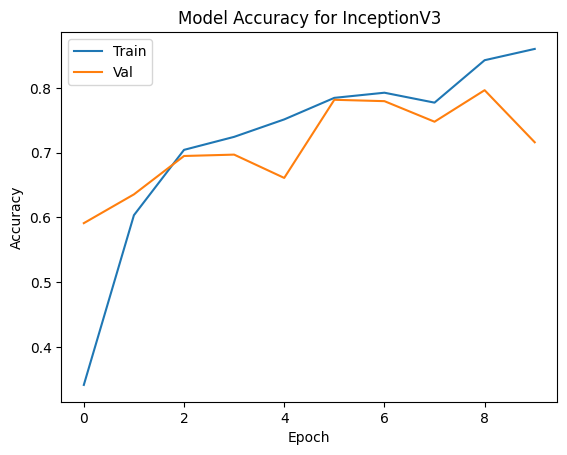

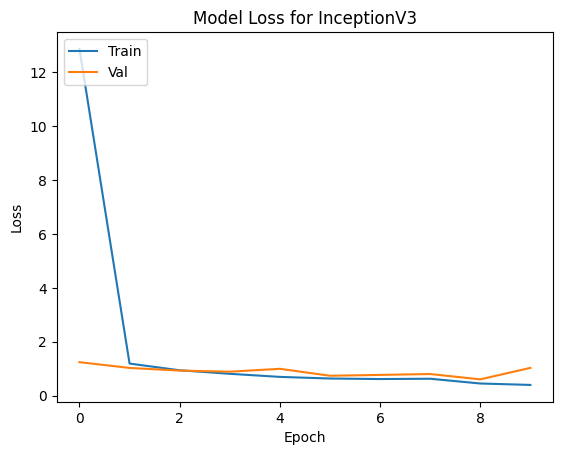

1/1 [==============================] - 0s 413ms/step


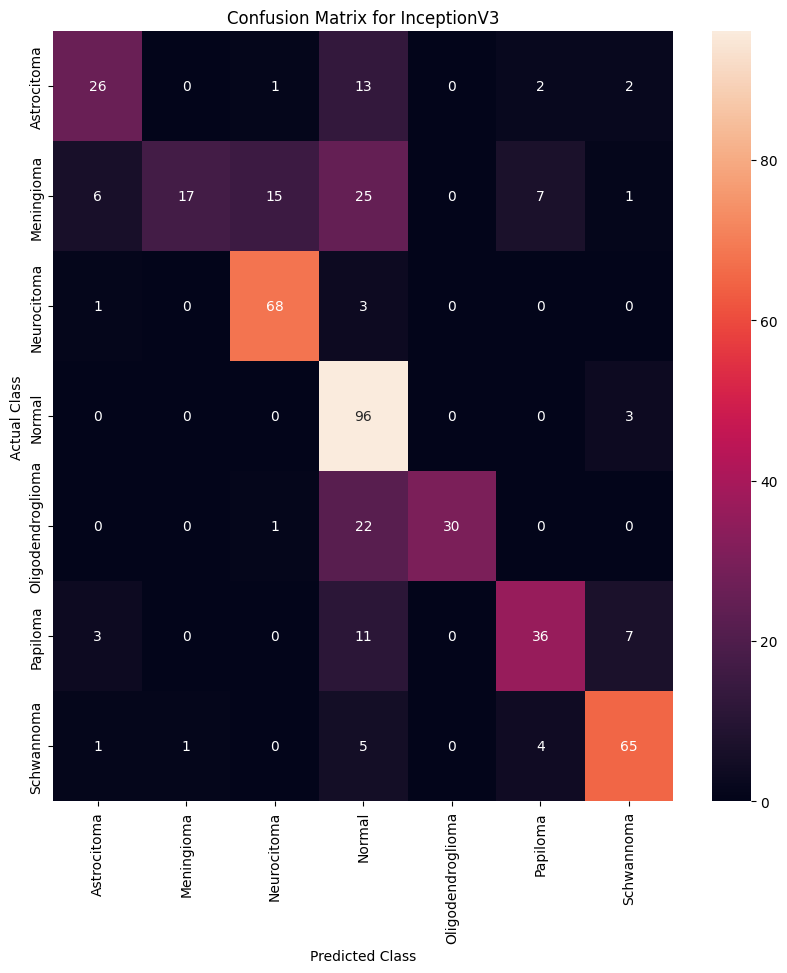

                   precision    recall  f1-score   support

      Astrocitoma       0.70      0.59      0.64        44
       Meningioma       0.94      0.24      0.38        71
      Neurocitoma       0.80      0.94      0.87        72
           Normal       0.55      0.97      0.70        99
Oligodendroglioma       1.00      0.57      0.72        53
         Papiloma       0.73      0.63      0.68        57
       Schwannoma       0.83      0.86      0.84        76

         accuracy                           0.72       472
        macro avg       0.79      0.69      0.69       472
     weighted avg       0.78      0.72      0.70       472



In [84]:
# Plotting the training and validation accuracy
plt.plot(history_inceptionv3.history['accuracy'])
plt.plot(history_inceptionv3.history['val_accuracy'])
plt.title('Model Accuracy for InceptionV3')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plotting the training and validation loss
plt.plot(history_inceptionv3.history['loss'])
plt.plot(history_inceptionv3.history['val_loss'])
plt.title('Model Loss for InceptionV3')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Get actual labels from the validation dataset
y_pred_inceptionv3 = []
y_actual_inceptionv3 = []

# use GPU for prediction
with tf.device('/GPU:0'):
    for images, labels in val_ds:
        
        # predict
        predictions = model_inceptionv3.predict(images)
        # get the predicted class
        predicted_class = np.argmax(predictions, axis=1)
        
        # append the predicted class
        for pred in predicted_class:
            y_pred_inceptionv3.append(pred)

        for label in labels:
            y_actual_inceptionv3.append(label)

# Plotting the confusion matrix
cm = confusion_matrix(y_actual_inceptionv3, y_pred_inceptionv3)
plt.figure(figsize=(10, 10))

# Set the labels based on the class names
labels = class_names

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for InceptionV3')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Print the classification report
print(classification_report(y_actual_inceptionv3, y_pred_inceptionv3, target_names=class_names))

Training MobileNetV2 Model

In [77]:
#Train a MobileNetV2 model, and removing the last layer (the classification layer)
base_model_mobilenetv2 = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_mobilenetv2.trainable = False

#Adding a new classification layer
x = base_model_mobilenetv2.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)

predictions = layers.Dense(7, activation='softmax')(x)

#Creating a new model
model_mobilenetv2 = Model(inputs=base_model_mobilenetv2.input, outputs=predictions)

#Compiling the model
model_mobilenetv2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# use GPU for model fitting
with tf.device('/GPU:0'):
    history_mobilenetv2 = model_mobilenetv2.fit(train_ds, epochs=10, validation_data=val_ds)
 

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
60/60 [==============================] - 26s 398ms/step - loss: 1.3874 - accuracy: 0.5426 - val_loss: 1.0430 - val_accuracy: 0.6335
Epoch 2/10
60/60 [==============================] - 24s 403ms/step - loss: 0.7301 - accuracy: 0.7425 - val_loss: 0.7407 - val_accuracy: 0.7436
Epoch 3/10
60/60 [==============================] - 26s 428ms/step - loss: 0.5549 - accuracy: 0.7953 - val_loss: 0.7371 - val_accuracy: 0.7542
Epoch 4/10
60/60 [==============================] - 27s 442ms/step - loss: 0.4214 - accuracy: 0.8477 - val_loss: 0.4959 - val_accuracy: 0.8453
Epoch 5/10
60/60 [==============================] - 27s 447ms/step - loss: 0.3288 - accuracy: 0.8889 - val_loss: 0.4518 - val_accuracy: 0.8559
Epoch 6/10
60/60 [==============================] - 27s 442ms/step - loss: 0.2673 - accuracy: 0.9064 - val_loss: 0.5226 - val_accuracy: 0.8347
Epoch 7/10
60/60 [==============================] - 27s 446ms/step - loss: 0.21

Plotting MobileNetV2 Model Accuraccy, Loss and Cofusion Matrix

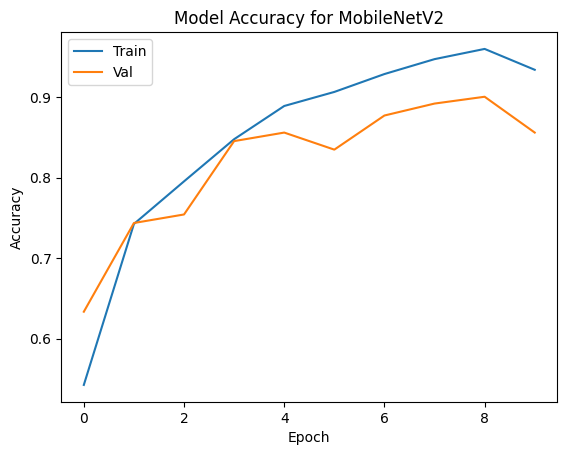

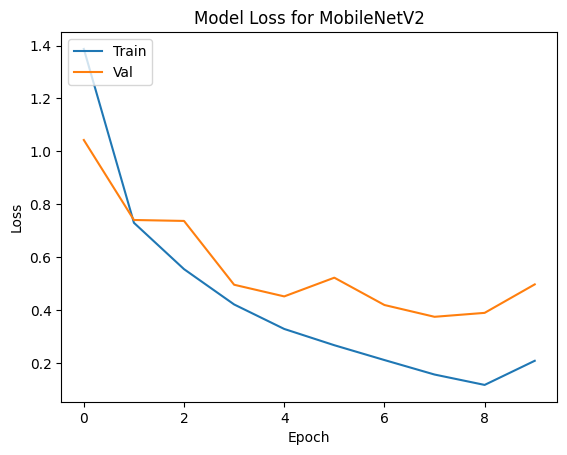

1/1 [==============================] - 0s 261ms/step


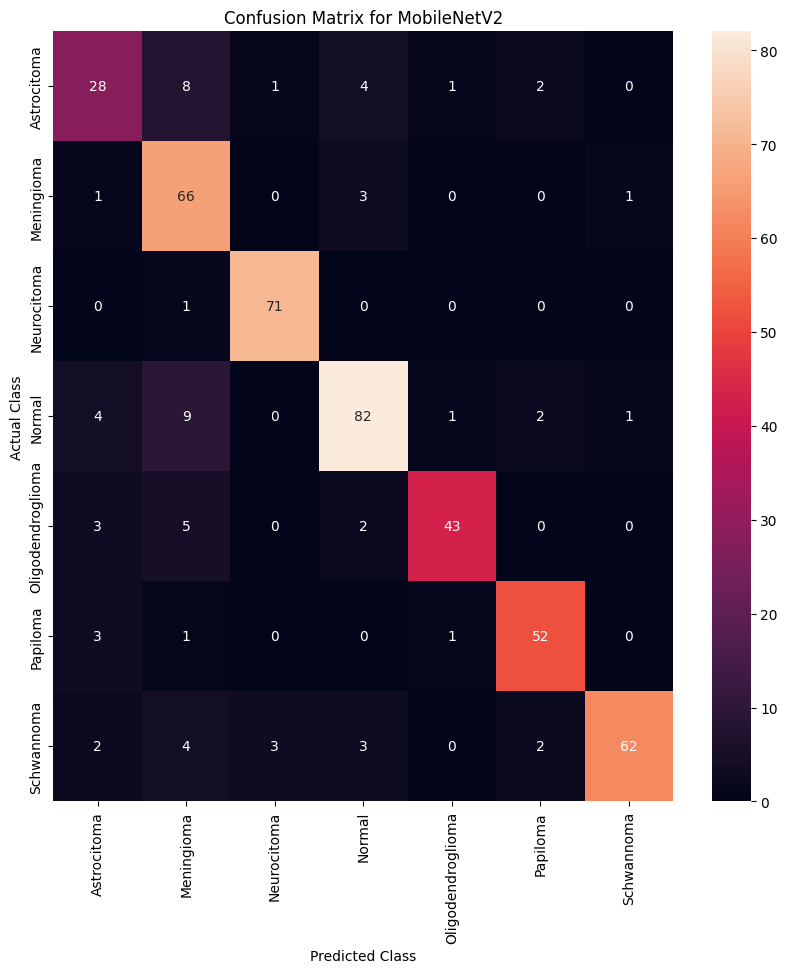

                   precision    recall  f1-score   support

      Astrocitoma       0.68      0.64      0.66        44
       Meningioma       0.70      0.93      0.80        71
      Neurocitoma       0.95      0.99      0.97        72
           Normal       0.87      0.83      0.85        99
Oligodendroglioma       0.93      0.81      0.87        53
         Papiloma       0.90      0.91      0.90        57
       Schwannoma       0.97      0.82      0.89        76

         accuracy                           0.86       472
        macro avg       0.86      0.85      0.85       472
     weighted avg       0.87      0.86      0.86       472



In [83]:
# Plotting the training and validation accuracy
plt.plot(history_mobilenetv2.history['accuracy'])

plt.plot(history_mobilenetv2.history['val_accuracy'])
plt.title('Model Accuracy for MobileNetV2')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plotting the training and validation loss
plt.plot(history_mobilenetv2.history['loss'])
plt.plot(history_mobilenetv2.history['val_loss'])
plt.title('Model Loss for MobileNetV2')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Get actual labels from the validation dataset
y_pred_mobilenetv2 = []
y_actual_mobilenetv2 = []

# use GPU for prediction
with tf.device('/GPU:0'):
    for images, labels in val_ds:
        
        # predict
        predictions = model_mobilenetv2.predict(images)
        # get the predicted class
        predicted_class = np.argmax(predictions, axis=1)
        
        # append the predicted class
        for pred in predicted_class:
            y_pred_mobilenetv2.append(pred)
        
        for label in labels:
            y_actual_mobilenetv2.append(label)

# Plotting the confusion matrix
cm = confusion_matrix(y_actual_mobilenetv2, y_pred_mobilenetv2)
plt.figure(figsize=(10, 10))

# Set the labels based on the class names
labels = class_names

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for MobileNetV2')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Print the classification report
print(classification_report(y_actual_mobilenetv2, y_pred_mobilenetv2, target_names=class_names))

Training DesneNet201 Model

In [80]:
#Train a DenseNet201 model, and removing the last layer (the classification layer)
base_model_densenet201 = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_densenet201.trainable = False

#Adding a new classification layer
x = base_model_densenet201.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)

predictions = layers.Dense(7, activation='softmax')(x)

#Creating a new model
model_densenet201 = Model(inputs=base_model_densenet201.input, outputs=predictions)

#Compiling the model
model_densenet201.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# use GPU for model fitting
with tf.device('/GPU:0'):
    history_densenet201 = model_densenet201.fit(train_ds, epochs=10, validation_data=val_ds)

74836368/74836368 [==============================] - 1s 0us/step
Epoch 1/10
60/60 [==============================] - 152s 2s/step - loss: 2.6547 - accuracy: 0.4564 - val_loss: 1.1312 - val_accuracy: 0.6483
Epoch 2/10
60/60 [==============================] - 140s 2s/step - loss: 0.8737 - accuracy: 0.6991 - val_loss: 0.7981 - val_accuracy: 0.6949
Epoch 3/10
60/60 [==============================] - 144s 2s/step - loss: 0.6970 - accuracy: 0.7546 - val_loss: 0.7305 - val_accuracy: 0.7479
Epoch 4/10
60/60 [==============================] - 143s 2s/step - loss: 0.5579 - accuracy: 0.8049 - val_loss: 0.7313 - val_accuracy: 0.7606
Epoch 5/10
60/60 [==============================] - 121s 2s/step - loss: 0.4751 - accuracy: 0.8355 - val_loss: 0.6643 - val_accuracy: 0.7797
Epoch 6/10
60/60 [==============================] - 123s 2s/step - loss: 0.3758 - accuracy: 0.8768 - val_loss: 0.6875 - val_accuracy: 0.7966
Epoch 7/10
60/60 [==============================] - 134s 2s/step - loss: 0.4272 - accurac

Plotting DenseNet201 Model Accuraccy, Loss and Cofusion Matrix

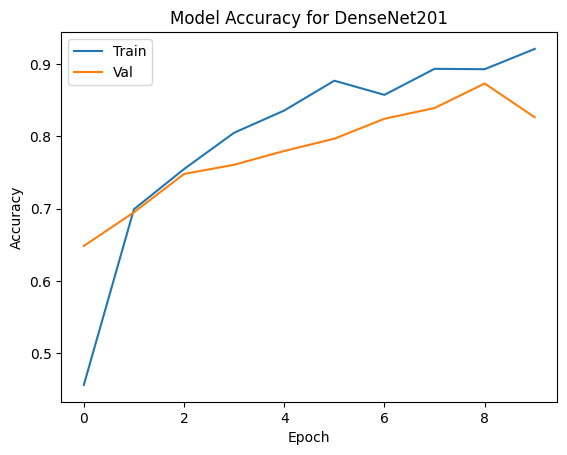

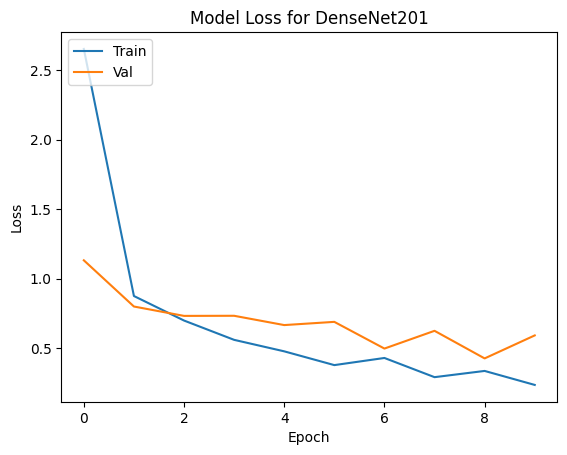

1/1 [==============================] - 2s 2s/step


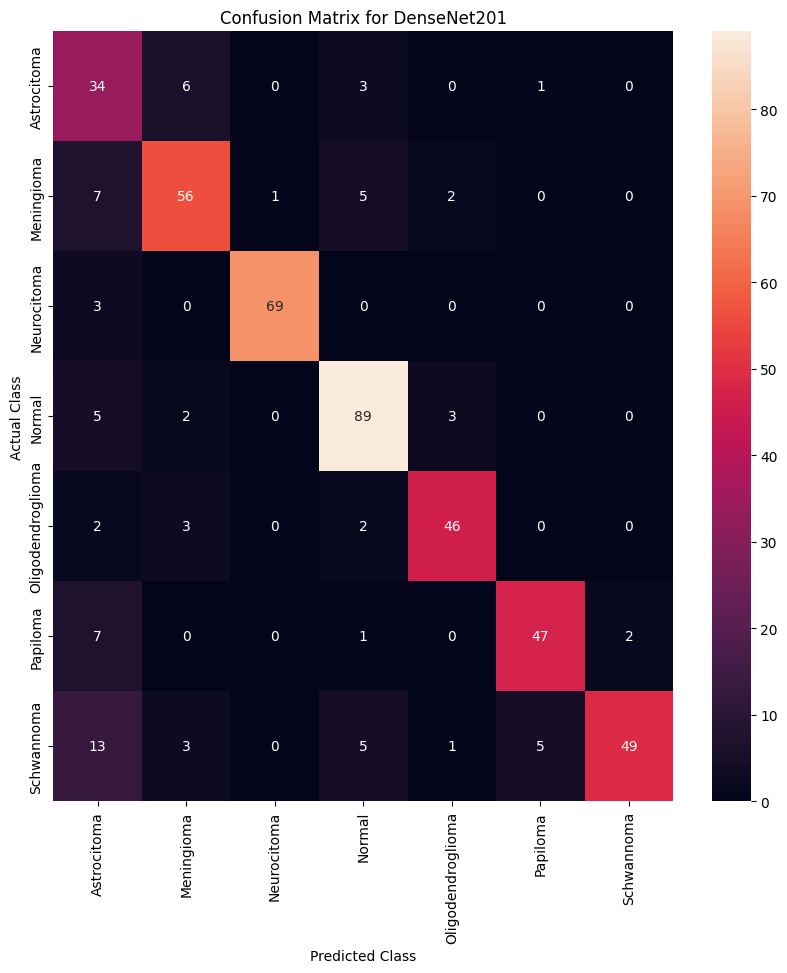

                   precision    recall  f1-score   support

      Astrocitoma       0.48      0.77      0.59        44
       Meningioma       0.80      0.79      0.79        71
      Neurocitoma       0.99      0.96      0.97        72
           Normal       0.85      0.90      0.87        99
Oligodendroglioma       0.88      0.87      0.88        53
         Papiloma       0.89      0.82      0.85        57
       Schwannoma       0.96      0.64      0.77        76

         accuracy                           0.83       472
        macro avg       0.83      0.82      0.82       472
     weighted avg       0.85      0.83      0.83       472



In [82]:
# Plotting the training and validation accuracy
plt.plot(history_densenet201.history['accuracy'])
plt.plot(history_densenet201.history['val_accuracy'])
plt.title('Model Accuracy for DenseNet201')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plotting the training and validation loss
plt.plot(history_densenet201.history['loss'])
plt.plot(history_densenet201.history['val_loss'])
plt.title('Model Loss for DenseNet201')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Get actual labels from the validation dataset
y_pred_densenet201 = []
y_actual_densenet201 = []

# use GPU for prediction
with tf.device('/GPU:0'):
    for images, labels in val_ds:
        
        # predict
        predictions = model_densenet201.predict(images)
        # get the predicted class
        predicted_class = np.argmax(predictions, axis=1)
        
        # append the predicted class
        for pred in predicted_class:
            y_pred_densenet201.append(pred)
        
        for label in labels:
            y_actual_densenet201.append(label)

# Plotting the confusion matrix
cm = confusion_matrix(y_actual_densenet201, y_pred_densenet201)
plt.figure(figsize=(10, 10))

# Set the labels based on the class names
labels = class_names

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for DenseNet201')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Print the classification report
print(classification_report(y_actual_densenet201, y_pred_densenet201, target_names=class_names))